Analysis for the weather in terms of latitude or the distance from the equator:

From the plotting of the graphs, the points are equally spaced corresponding to the cities across the world, both northern and southern hemisphere.

The temperature graph shows a clear markdown of higher temperatures closer to the equator at the present time. This data can vary with seasons as the northern hemisphere is more inclined towards the sun during certain times of the year and vice versa with the Southern hemisphere (Not shown).

The humidity, cloudiness and wind speed has little or significance in terms of correlation with Latitude. However, it is important to note that during winter months, the wind chill factor is significant in terms of temperature. So, it is indirectly related to temperature making the areas farther from the equator colder. This is not shown in the following graphical analysis.

Overall conclusion from the data analysis reveals that it is warmer as you approach the equator.

- Deepa Karnani

In [1]:

#Dependencies#Depend 
from citipy import citipy
from config import openweatherkey
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import json
import gzip
import unidecode
import time
from config import openweatherkey

In [2]:
# Build data frame of randomly generated lat and long
coordinates = pd.DataFrame()
coordinates['lat_dist'] = np.random.uniform(-90,90, 1700)
coordinates['lng_dist'] = np.random.uniform(-180, 180, 1700)

coordinates.to_csv("Output/Weatherdata")

In [3]:
# Call citipy file to get nearest city based on random lat and lng
# add closest city and country column
coordinates['closest_city'] = ""
coordinates['country'] = ""

#find and add closest city and country code
for index, row in coordinates.iterrows():
    lat = row['lat_dist']
    lng = row['lng_dist']
    coordinates.set_value(index, 'closest_city', citipy.nearest_city(lat, lng).city_name)
    coordinates.set_value(index, 'country', citipy.nearest_city(lat, lng).country_code)

C:\Users\dinot\AppData\Local\conda\conda\envs\pythondata\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # Remove the CWD from sys.path while we load stuff.
C:\Users\dinot\AppData\Local\conda\conda\envs\pythondata\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [4]:
    
# Test to see if the random city is already in the list, if not, add it to the city and country lists
# delete repeated cities and find unique city count
coordinates = coordinates.drop_duplicates(['closest_city', 'country'])
coordinates = coordinates.dropna()
len(coordinates['closest_city'].value_counts())

681

In [5]:
coordinates = coordinates[['closest_city', 'country']]
coordinates.head()

closest_city country
0  new norfolk      au
1   butaritari      ki
2    taolanaro      mg
3       knysna      za
4    sembabule      ug

In [6]:

#rename column
coordinates = coordinates.rename(columns = {'closest_city': 'city'})

for index, row in coordinates.iterrows():
    upcase_country = row['country'].upper() # make all two digit country codes capital
    coordinates.set_value(index, 'country', upcase_country) # reset the value of country to uppercase
    cap_city = row['city'].title() # make all city codes capital
    coordinates.set_value(index, 'city', cap_city) # reset the value
    unaccented = unidecode.unidecode(cap_city) # strip accents from city name
    coordinates.set_value(index, 'city', unaccented) # reset the value of name (city) to stripped down version


C:\Users\dinot\AppData\Local\conda\conda\envs\pythondata\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  import sys
C:\Users\dinot\AppData\Local\conda\conda\envs\pythondata\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
C:\Users\dinot\AppData\Local\conda\conda\envs\pythondata\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  # This is added back by InteractiveShellApp.init_path()


In [7]:
coordinates.head()

city country
0  New Norfolk      AU
1   Butaritari      KI
2    Taolanaro      MG
3       Knysna      ZA
4    Sembabule      UG

In [8]:
# downloaded from http://openweathermap.org/help/city_list.txt
cities_id = pd.DataFrame()
cities_id = pd.read_csv("city_id_list.csv")
cities_id.head()
cities_id.dtypes

id               int64
nm              object
lat            float64
lon            float64
countryCode     object
dtype: object

In [9]:
# with gzip.open("city.list.json.gz", "rb") as f:
#     citi_data = json.loads(f.read().decode("ansi"))
# #     citi_df = pd.DataFrame([citi_data])

#rename columns

cities_id = cities_id.rename(columns = {'nm': 'city', 'countryCode': 'country'})

#merge data and clean
merged_df = coordinates.merge(cities_id, how = 'left', on = ('city', 'country'))
merged_df = merged_df.drop_duplicates(['city', 'country'])
merged_df = merged_df.dropna()
merged_df['id'] = merged_df['id'].round(0).astype('int')
merged_df.head()
# merged_df.dtypes

city country       id        lat         lon
0     New Norfolk      AU  2155415 -42.782612  147.058701
3          Knysna      ZA   988698 -34.036270   23.047131
4       Sembabule      UG   226361  -0.077220   31.456671
5  Saint-Philippe      RE   935215 -21.358521   55.767948
7          Beloha      MG  1067565 -25.166670   45.049999

In [10]:
#verifying count
# merged_df.reset_index()
merged_df.set_index('id')
merged_df.head()

city country       id        lat         lon
0     New Norfolk      AU  2155415 -42.782612  147.058701
3          Knysna      ZA   988698 -34.036270   23.047131
4       Sembabule      UG   226361  -0.077220   31.456671
5  Saint-Philippe      RE   935215 -21.358521   55.767948
7          Beloha      MG  1067565 -25.166670   45.049999

In [11]:
#leave merged_df the same from here on
weather_data = merged_df.copy()

In [12]:
# Open Weather Maps Api example links for reference
# id url example: 'api.openweathermap.org/data/2.5/weather?id=2172797'
# remember to use &appid= for key
counter = 0 #for breaking and pausing
current_error_list = [] # for cities without data from current weather
current_errors = 0  #current weather pull errors

In [13]:
#at time of pull
weather_data['current_temp'] = ""
weather_data['current_humidity'] = ""
weather_data['current_clouds'] = ""
weather_data['current_wind'] = ""
params = {"key": openweatherkey}
param = {"key": openweatherkey} 

In [14]:
t0 = time.time() #for pause timer
for index, row in weather_data.iterrows():
    time.sleep(1)
    base_url = "https://api.openweathermap.org/data/2.5/weather?id="
    units = "Imperial"
    city_id = row['id']

    # update address key value
    params['address'] = f"{city_id}"

   
  
    # convert to json
    
#     country_city = country_city.json()

    query_url = base_url + str(city_id) +"&appid=" + openweatherkey + "&units=" + units
    print('Now retrieving data for city id #%s:%s %s, %s' % (index, row['id'], row['city'], row['country']))
    try: 
        if row['id'] != 0: # use if if ID exists
#         current_url = 'https://api.openweathermap.org/data/2.5/weather?id=%s&APPID=%s&units=imperial' % (loc_id, wkey)
            cities_data = requests.get(query_url, params=params)
            cities_data = cities_data.json()
            weather_data.loc[index, 'current_temp'] = cities_data['main']['temp']
            weather_data.loc[index, 'current_humidity'] = cities_data['main']['humidity']
            weather_data.loc[index, 'current_clouds'] = cities_data['clouds']['all']
            weather_data.loc[index, 'current_wind'] = cities_data['wind']['speed']
        else: #use city and country if no id AND no coordinates
#        
           print(cities_data.url + str('Missing Current Weather Info for city'))
     
    except:
#         print('Missing Current Weather Info for city #%s:%s %s, %s' % (index, row['id'], row['city'], row['country']))
        current_error_list.append(index)
        current_errors += 1
    
    
    print('---------------------------------------------------------------------------')
    print("Now retieving city # " + str(counter))
    print(query_url)
    counter +=1
    if counter % 10 == 0: #because two records pulled for each city 
        t1 = time.time() #records time very 30 records
        sl_time = 90 - (t1-t0) # calculates buffer for api pull limit
        print("")
        print('********Sleeping for %s seconds.********' % (sl_time))
        print("")
        time.sleep(sl_time) # pauses for appropraite amount of time
        t0 = time.time() # resets for next 30 pull timer
#     if counter == 5:
#         break

Now retrieving data for city id #0:2155415 New Norfolk, AU
---------------------------------------------------------------------------
Now retieving city # 0
https://api.openweathermap.org/data/2.5/weather?id=2155415&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #3:988698 Knysna, ZA
---------------------------------------------------------------------------
Now retieving city # 1
https://api.openweathermap.org/data/2.5/weather?id=988698&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #4:226361 Sembabule, UG
---------------------------------------------------------------------------
Now retieving city # 2
https://api.openweathermap.org/data/2.5/weather?id=226361&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #5:935215 Saint-Philippe, RE
---------------------------------------------------------------------------
Now retieving city # 3
https://api.openweathermap.org/data/2.

Now retrieving data for city id #47:1214488 Meulaboh, ID
---------------------------------------------------------------------------
Now retieving city # 30
https://api.openweathermap.org/data/2.5/weather?id=1214488&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #48:964420 Port Elizabeth, ZA
---------------------------------------------------------------------------
Now retieving city # 31
https://api.openweathermap.org/data/2.5/weather?id=964420&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #49:4032243 Vaini, TO
---------------------------------------------------------------------------
Now retieving city # 32
https://api.openweathermap.org/data/2.5/weather?id=4032243&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #51:3618908 Juigalpa, NI
---------------------------------------------------------------------------
Now retieving city # 33
https://api.openweathermap.org/d

Now retrieving data for city id #93:2126199 Cherskiy, RU
---------------------------------------------------------------------------
Now retieving city # 60
https://api.openweathermap.org/data/2.5/weather?id=2126199&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #94:2017155 Saskylakh, RU
---------------------------------------------------------------------------
Now retieving city # 61
https://api.openweathermap.org/data/2.5/weather?id=2017155&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #95:587207 Artyom, AZ
---------------------------------------------------------------------------
Now retieving city # 62
https://api.openweathermap.org/data/2.5/weather?id=587207&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #98:2015306 Tiksi, RU
---------------------------------------------------------------------------
Now retieving city # 63
https://api.openweathermap.org/data/2.5

Now retrieving data for city id #143:2281120 Tabou, CI
---------------------------------------------------------------------------
Now retieving city # 90
https://api.openweathermap.org/data/2.5/weather?id=2281120&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #144:2158767 Mareeba, AU
---------------------------------------------------------------------------
Now retieving city # 91
https://api.openweathermap.org/data/2.5/weather?id=2158767&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #146:2513222 Nijar, ES
---------------------------------------------------------------------------
Now retieving city # 92
https://api.openweathermap.org/data/2.5/weather?id=2513222&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #147:286245 Sur, OM
---------------------------------------------------------------------------
Now retieving city # 93
https://api.openweathermap.org/data/2.5/we

Now retrieving data for city id #190:6100799 Pemberton, CA
---------------------------------------------------------------------------
Now retieving city # 120
https://api.openweathermap.org/data/2.5/weather?id=6100799&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #191:3424934 Saint-Pierre, PM
---------------------------------------------------------------------------
Now retieving city # 121
https://api.openweathermap.org/data/2.5/weather?id=3424934&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #192:3650273 Velasco Ibarra, EC
---------------------------------------------------------------------------
Now retieving city # 122
https://api.openweathermap.org/data/2.5/weather?id=3650273&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #193:889191 Karoi, ZW
---------------------------------------------------------------------------
Now retieving city # 123
https://api.openwe

Now retrieving data for city id #245:3529654 Dzilam Gonzalez, MX
---------------------------------------------------------------------------
Now retieving city # 150
https://api.openweathermap.org/data/2.5/weather?id=3529654&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #247:780643 Bjornevatn, NO
---------------------------------------------------------------------------
Now retieving city # 151
https://api.openweathermap.org/data/2.5/weather?id=780643&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #248:1175012 Kandiari, PK
---------------------------------------------------------------------------
Now retieving city # 152
https://api.openweathermap.org/data/2.5/weather?id=1175012&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #249:5423573 Grand Junction, US
---------------------------------------------------------------------------
Now retieving city # 153
https://api.

Now retrieving data for city id #286:2174444 Bowen, AU
---------------------------------------------------------------------------
Now retieving city # 180
https://api.openweathermap.org/data/2.5/weather?id=2174444&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #287:2021017 Kysyl-Syr, RU
---------------------------------------------------------------------------
Now retieving city # 181
https://api.openweathermap.org/data/2.5/weather?id=2021017&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #288:5742974 North Bend, US
---------------------------------------------------------------------------
Now retieving city # 182
https://api.openweathermap.org/data/2.5/weather?id=5742974&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #290:2246452 Saint-Louis, SN
---------------------------------------------------------------------------
Now retieving city # 183
https://api.openweathe

Now retrieving data for city id #332:2122389 Ossora, RU
---------------------------------------------------------------------------
Now retieving city # 210
https://api.openweathermap.org/data/2.5/weather?id=2122389&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #333:2017215 Sangar, RU
---------------------------------------------------------------------------
Now retieving city # 211
https://api.openweathermap.org/data/2.5/weather?id=2017215&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #335:3840300 Presidencia Roque Saenz Pena, AR
---------------------------------------------------------------------------
Now retieving city # 212
https://api.openweathermap.org/data/2.5/weather?id=3840300&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #336:926308 Monkey Bay, MW
---------------------------------------------------------------------------
Now retieving city # 213
https://

Now retrieving data for city id #375:286621 Salalah, OM
---------------------------------------------------------------------------
Now retieving city # 240
https://api.openweathermap.org/data/2.5/weather?id=286621&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #376:244878 Biltine, TD
---------------------------------------------------------------------------
Now retieving city # 241
https://api.openweathermap.org/data/2.5/weather?id=244878&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #377:3577154 Oranjestad, AW
---------------------------------------------------------------------------
Now retieving city # 242
https://api.openweathermap.org/data/2.5/weather?id=3577154&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #378:1624725 Tarakan, ID
---------------------------------------------------------------------------
Now retieving city # 243
https://api.openweathermap.org

Now retrieving data for city id #411:1486321 Yar-Sale, RU
---------------------------------------------------------------------------
Now retieving city # 270
https://api.openweathermap.org/data/2.5/weather?id=1486321&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #412:1801615 Maba, CN
---------------------------------------------------------------------------
Now retieving city # 271
https://api.openweathermap.org/data/2.5/weather?id=1801615&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #415:64814 Bandarbeyla, SO
---------------------------------------------------------------------------
Now retieving city # 272
https://api.openweathermap.org/data/2.5/weather?id=64814&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #416:5847486 Kailua, US
---------------------------------------------------------------------------
Now retieving city # 273
https://api.openweathermap.org/d

Now retrieving data for city id #463:5820705 Casper, US
---------------------------------------------------------------------------
Now retieving city # 300
https://api.openweathermap.org/data/2.5/weather?id=5820705&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #464:2964782 Dingle, IE
---------------------------------------------------------------------------
Now retieving city # 301
https://api.openweathermap.org/data/2.5/weather?id=2964782&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #468:894701 Bulawayo, ZW
---------------------------------------------------------------------------
Now retieving city # 302
https://api.openweathermap.org/data/2.5/weather?id=894701&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #470:3395981 Maceio, BR
---------------------------------------------------------------------------
Now retieving city # 303
https://api.openweathermap.org/da

Now retrieving data for city id #518:2399001 Mayumba, GA
---------------------------------------------------------------------------
Now retieving city # 330
https://api.openweathermap.org/data/2.5/weather?id=2399001&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #520:5859699 College, US
---------------------------------------------------------------------------
Now retieving city # 331
https://api.openweathermap.org/data/2.5/weather?id=5859699&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #521:508068 Podosinovets, RU
---------------------------------------------------------------------------
Now retieving city # 332
https://api.openweathermap.org/data/2.5/weather?id=508068&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #523:3833859 Tres Arroyos, AR
---------------------------------------------------------------------------
Now retieving city # 333
https://api.openweath

Now retrieving data for city id #563:2214827 Mizdah, LY
---------------------------------------------------------------------------
Now retieving city # 360
https://api.openweathermap.org/data/2.5/weather?id=2214827&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #564:543246 Kozhva, RU
---------------------------------------------------------------------------
Now retieving city # 361
https://api.openweathermap.org/data/2.5/weather?id=543246&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #565:1492566 Severo-Yeniseyskiy, RU
---------------------------------------------------------------------------
Now retieving city # 362
https://api.openweathermap.org/data/2.5/weather?id=1492566&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #566:750938 Bayburt, TR
---------------------------------------------------------------------------
Now retieving city # 363
https://api.openweather

Now retrieving data for city id #604:3361934 Saldanha, ZA
---------------------------------------------------------------------------
Now retieving city # 390
https://api.openweathermap.org/data/2.5/weather?id=3361934&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #605:3391889 Pitimbu, BR
---------------------------------------------------------------------------
Now retieving city # 391
https://api.openweathermap.org/data/2.5/weather?id=3391889&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #606:2068110 Kununurra, AU
---------------------------------------------------------------------------
Now retieving city # 392
https://api.openweathermap.org/data/2.5/weather?id=2068110&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #607:3133895 Tromso, NO
---------------------------------------------------------------------------
Now retieving city # 393
https://api.openweathermap.

Now retrieving data for city id #646:516615 Nyazepetrovsk, RU
---------------------------------------------------------------------------
Now retieving city # 420
https://api.openweathermap.org/data/2.5/weather?id=516615&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #647:3894426 Coihaique, CL
---------------------------------------------------------------------------
Now retieving city # 421
https://api.openweathermap.org/data/2.5/weather?id=3894426&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #649:949683 Thabazimbi, ZA
---------------------------------------------------------------------------
Now retieving city # 422
https://api.openweathermap.org/data/2.5/weather?id=949683&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #650:3904793 Santa Rosa, BO
---------------------------------------------------------------------------
Now retieving city # 423
https://api.openwea

Now retrieving data for city id #687:5849996 Lahaina, US
---------------------------------------------------------------------------
Now retieving city # 450
https://api.openweathermap.org/data/2.5/weather?id=5849996&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #688:560191 Gordeyevka, RU
---------------------------------------------------------------------------
Now retieving city # 451
https://api.openweathermap.org/data/2.5/weather?id=560191&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #689:3577430 Road Town, VG
---------------------------------------------------------------------------
Now retieving city # 452
https://api.openweathermap.org/data/2.5/weather?id=3577430&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #690:321191 Beysehir, TR
---------------------------------------------------------------------------
Now retieving city # 453
https://api.openweathermap

Now retrieving data for city id #745:703537 Kuteynykove, UA
---------------------------------------------------------------------------
Now retieving city # 480
https://api.openweathermap.org/data/2.5/weather?id=703537&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #746:3652758 Puerto Baquerizo Moreno, EC
---------------------------------------------------------------------------
Now retieving city # 481
https://api.openweathermap.org/data/2.5/weather?id=3652758&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #748:3936456 Lima, PE
---------------------------------------------------------------------------
Now retieving city # 482
https://api.openweathermap.org/data/2.5/weather?id=3936456&appid=5580baaefa2bed44aa5e1d152e482231&units=Imperial
Now retrieving data for city id #750:3386177 Trairi, BR
---------------------------------------------------------------------------
Now retieving city # 483
https://api.ope

In [15]:
print(current_error_list)

[]


In [16]:
weather_data

city country       id        lat         lon  \
0                New Norfolk      AU  2155415 -42.782612  147.058701   
3                     Knysna      ZA   988698 -34.036270   23.047131   
4                  Sembabule      UG   226361  -0.077220   31.456671   
5             Saint-Philippe      RE   935215 -21.358521   55.767948   
7                     Beloha      MG  1067565 -25.166670   45.049999   
8                   Klaksvik      FO  2618795  62.226551   -6.589010   
10                      Tura      RU  2014833  64.283333  100.250000   
11                 Busselton      AU  2075265 -33.650002  115.333328   
12                 Carnarvon      AU  2074865 -24.866671  113.633331   
13                 Wattegama      LK  1224061   6.798900   81.480797   
15                Sao Filipe      CV  3374210  14.896100  -24.495560   
18                  Coquimbo      CL  3893629 -29.953329  -71.343613   
19               East London      ZA  1006984 -33.015289   27.911619   
21                     Tobol      KZ  1518139  52.684441   62.579441   
22                   Ushuaia      AR  3833367 -54.799999  -68.300003   
23                  Lorengau      PG  2092164  -2.022590  147.271194   
26                  Suraabad      AZ   584991  40.819241   49.468739   
27                  Waycross      US  4229763  31.213551  -82.354019   
29               Port Alfred      ZA   964432 -33.590569   26.891041   
30                    Albany      AU  2077963 -35.016941  117.891670   
32                 Grindavik      IS  3416888  63.842400  -22.433750   
34              Puerto Ayora      EC  3652764  -0.739310  -90.351761   
36                 Jamestown      SH  3370903 -15.938720   -5.716750   
37               Peace River      CA  6100069  56.250099 -117.285988   
38                Hinesville      US  4200671  31.846880  -81.595947   
39              Punta Arenas      CL  3874787 -53.150002  -70.916672   
40             Krasnoyarskiy      RU   542133  51.965000   59.896671   
41                 Dongsheng      CN  1812256  39.816078  109.977631   
44                    Motema      SL  2405038   8.600000  -11.033330   
45                    Sorong      ID  1626542  -0.883330  131.250000   
..                       ...     ...      ...        ...         ...   
699                Egvekinot      RU  4031742  66.316673 -179.166672   
701                   Bolobo      CD  2316748  -2.166670   16.233330   
703                  Aloleng      PH  1731298  16.130699  119.782402   
706            Casas Grandes      MX  4015076  30.366671 -107.949997   
707                  Clinton      US  4351871  38.765110  -76.898308   
727                 Baherden      TM   162158  38.436241   57.431580   
728                  Punalur      IN  1259243   9.000000   76.933327   
729                Tilichiki      RU  2120591  60.466671  166.100006   
730                 Nelidovo      RU   522775  56.221069   32.777382   
731               Betare Oya      CM  2234339   5.600000   14.083330   
732                   Suntar      RU  2015913  62.144440  117.631943   
733                   Boende      CD   218680  -0.216670   20.866671   
734                    Semey      KZ  1519422  50.411110   80.227501   
735                   Najran      SA   103630  17.492399   44.127659   
736            Ponta Delgada      PT  3372783  37.733330  -25.666670   
737                 Chiredzi      ZW   893485 -21.049999   31.666670   
738                  Codajas      BR  3664525  -3.836670  -62.056938   
739                   Hirara      JP  1862505  24.799999  125.283333   
742                 Tangping      CN  1793364  22.026470  111.932289   
743                   Olinda      BR  3393536  -8.008890  -34.855282   
744                   Maputo      MZ  1040652 -25.965281   32.589169   
745              Kuteynykove      UA   703537  47.812271   38.288219   
746  Puerto Baquerizo Moreno      EC  3652758  -0.900000  -89.599998   
748                     Lima      PE  3936456 -12.043180  -77.02

In [18]:
weather_data.to_csv("WeatherData.csv", index=False)

PermissionError: [Errno 13] Permission denied: 'WeatherData.csv'

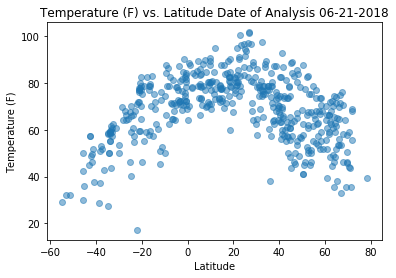

In [19]:
plt.scatter(weather_data["lat"],weather_data["current_temp"], alpha = 0.5)

plt.title("Temperature (F) vs. Latitude Date of Analysis 06-21-2018")
plt.xlabel("Latitude")
plt.ylabel("Temperature (F)")
plt.savefig("Temperature_Vs_Latitude.png")
plt.show()


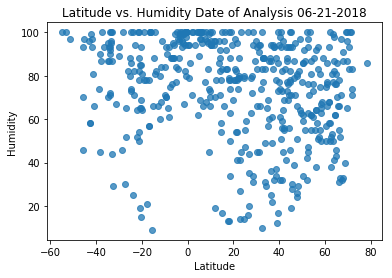

In [20]:
plt.scatter(weather_data["lat"],weather_data["current_humidity"], alpha = 0.75)

plt.title("Latitude vs. Humidity Date of Analysis 06-21-2018")
plt.xlabel("Latitude")
plt.ylabel("Humidity")
plt.savefig("Humidity_Vs_Latitude.png")
plt.show()

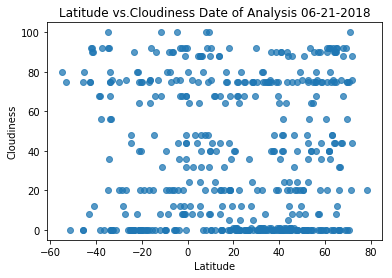

In [22]:
plt.scatter(weather_data["lat"],weather_data["current_clouds"], alpha = 0.75)

plt.title("Latitude vs.Cloudiness Date of Analysis 06-21-2018")
plt.xlabel("Latitude")
plt.ylabel("Cloudiness")
plt.savefig("Cloudiness_Vs_Latitude.png")
plt.show()

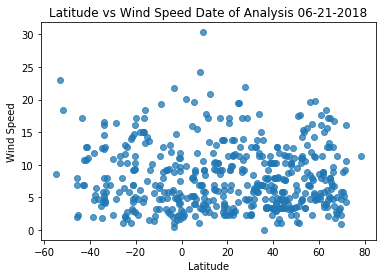

In [23]:
plt.scatter(weather_data["lat"],weather_data["current_wind"], alpha= 0.75)
plt.title("Latitude vs Wind Speed Date of Analysis 06-21-2018")
plt.xlabel("Latitude")
plt.ylabel("Wind Speed")
plt.savefig("Wind Speed_vs_Latitude.png")
plt.show()

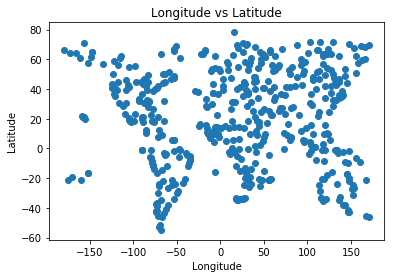

In [24]:
plt.scatter(weather_data["lon"],weather_data["lat"])
plt.title("Longitude vs Latitude")
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.savefig("Longitude_vs_Latitude.png")
plt.show()